# 1. Import libraries

In [1]:
# data manipulation
import numpy as np
import pandas as pd
from darts import TimeSeries

# data visualization
import matplotlib.pyplot as plt

# models
from darts.models import NaiveSeasonal

# metrics
from sklearn.metrics import mean_absolute_percentage_error

# warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
def take_backtest_horizon(backtests, horizon, last_horizon, observations, col):
    backtests_horizon_dates = [i[col].time_index[-1+horizon] for i in backtests[last_horizon-horizon:][:observations]]
    backtests_horizon_values = [i[col].values()[-1+horizon] for i in backtests[last_horizon-horizon:][:observations]]
    
    backtests_horizon = TimeSeries.from_times_and_values(times=pd.DatetimeIndex(backtests_horizon_dates), values=np.array(backtests_horizon_values))
    return backtests_horizon

In [3]:
def BIAS(y_true, y_pred):
    bias = (((np.sum(y_pred - y_true))/(np.sum(y_true))))
    return bias

# 2. Load data

In [4]:
dataset = pd.read_csv('../results/prepared_data.csv')

# set the column type for column with date
dataset['Data'] = pd.to_datetime(dataset['Data'], format='%Y-%m-%d')

dataset

,Data,GŁOGÓW (151160060) Stan wody [cm],RACIBÓRZ-MIEDONIA (150180060) Stan wody [cm],BARDO ŚLĄSKIE (250160410) Suma opadów [mm],BIERUTÓW (251170270) Suma opadów [mm],BOLESŁAWÓW (250160610) Suma opadów [mm],BOLKÓW (250160030) Suma opadów [mm],BORÓW (250160070) Suma opadów [mm],BRZEG (250170050) Suma opadów [mm],BRZEG DOLNY (251160230) Suma opadów [mm],...,TARNÓW (250160360) Suma opadów [mm],TRZEBNICA (251170210) Suma opadów [mm],TWARDOCICE (251150280) Suma opadów [mm],WALIM (250160270) Suma opadów [mm],WROCŁAW-STRACHOWICE (351160424) Suma opadów [mm],ZIELENIEC (250160530) Suma opadów [mm],ZIELINA (250170280) Suma opadów [mm],ŹRÓDŁA (251160370) Suma opadów [mm],średnia Suma opadów [mm],mediana Suma opadów [mm]
0,2012-01-01,199.0,119.0,0.2,0.5,0.5,0.7,0.2,NaN,0.8,...,0.8,NaN,0.5,0.0,0.3,7.0,0.5,NaN,0.721875,0.5
1,2012-01-02,197.0,116.0,NaN,1.1,1.0,0.8,0.0,0.3,0.6,...,0.0,0.5,2.2,0.1,0.2,1.3,NaN,NaN,0.888889,0.6
2,2012-01-03,197.0,118.0,2.2,0.9,5.6,NaN,0.0,NaN,0.1,...,0.0,0.1,NaN,0.2,0.1,9.5,NaN,NaN,1.406667,0.2
3,2012-01-04,204.0,127.0,2.4,0.1,12.5,NaN,NaN,0.6,0.5,...,1.1,1.8,0.2,5.2,0.0,12.6,0.9,NaN,3.620270,1.5
4,2012-01-05,205.0,153.0,8.9,7.1,23.0,10.2,0.5,1.0,3.0,...,6.6,8.8,9.3,12.9,2.5,46.0,6.1,NaN,10.271795,7.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3648,2021-12-27,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.000000,0.0
3649,2021-12-28,NaN,NaN,2.4,0.0,2.8,1.2,5.7,3.1,2.8,...,0.6,NaN,3.0,0.2,3.5,6.7,4.5,3.8,2.206579,2.1
3650,2021-12-29,NaN,NaN,0.2,2.3,0.0,0.5,0.7,1.0,0.5,...,0.1,NaN,0.8,0.0,1.3,3.2,1.1,0.9,0.562500,0.5
3651,2021-12-30,NaN,NaN,1.6,6.2,2.0,3.4,4.4,5.5,4.7,...,0.9,NaN,2.4,1.5,4.6,10.2,5.6,4.2,4.215789,4.2


In [5]:
hierarchy = pd.read_csv('../results/prepared_hierarchy.csv')

hierarchy

,id_meteo,name_meteo,id_hydro,name_hydro
0,251160080,GŁOGÓW,151160060,GŁOGÓW
1,350180540,RACIBÓRZ,150180060,RACIBÓRZ-MIEDONIA


In [6]:
hydro_cols = [f"{stations['name_hydro']} ({stations['id_hydro']}) Stan wody [cm]" for _, stations in hierarchy.loc[
                                            :, ['id_hydro', 'name_hydro']].drop_duplicates().iterrows()]
meteo_cols = [f"{stations['name_meteo']} ({stations['id_meteo']}) Suma opadów [mm]" for _, stations in hierarchy.loc[
                                            hierarchy['id_meteo']!=0, ['id_meteo', 'name_meteo']].drop_duplicates().iterrows()]

# 3. Save as TimeSeries Object

In [7]:
dataset.loc[:, ['Data']+hydro_cols]

,Data,GŁOGÓW (151160060) Stan wody [cm],RACIBÓRZ-MIEDONIA (150180060) Stan wody [cm]
0,2012-01-01,199.0,119.0
1,2012-01-02,197.0,116.0
2,2012-01-03,197.0,118.0
3,2012-01-04,204.0,127.0
4,2012-01-05,205.0,153.0
...,...,...,...
3648,2021-12-27,NaN,NaN
3649,2021-12-28,NaN,NaN
3650,2021-12-29,NaN,NaN
3651,2021-12-30,NaN,NaN


In [8]:
dataset_ts = TimeSeries.from_dataframe(df=dataset.loc[:, ['Data']+hydro_cols].dropna(),
                                       time_col='Data', value_cols=hydro_cols)

dataset_ts

<TimeSeries (DataArray) (Data: 3592, component: 2, sample: 1)>
array([[[199.],
        [119.]],

       [[197.],
        [116.]],

       [[197.],
        [118.]],

       ...,

       [[214.],
        [124.]],

       [[208.],
        [122.]],

       [[209.],
        [121.]]])
Coordinates:
  * Data       (Data) datetime64[ns] 2012-01-01 2012-01-02 ... 2021-10-31
  * component  (component) object 'GŁOGÓW (151160060) Stan wody [cm]' 'RACIBÓ...
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

# 3. Train Test Split

In [9]:
first_test_date = dataset.loc[:, ['Data']+hydro_cols].dropna()['Data'].values[-52]
first_test_date = pd.Timestamp(first_test_date)
first_test_date

Timestamp('2021-09-10 00:00:00')

In [10]:
train_dataset, test_dataset = dataset_ts.split_before(first_test_date)

# 4. Modelling & Backtests

In [11]:
# Założenie, że max horyzont to t0+30 days
horizons = 30

In [12]:
first_test_date - np.timedelta64(horizons-1, 'D')

Timestamp('2021-08-12 00:00:00')

## 4.1 Baseline

In [13]:
baseline_model = NaiveSeasonal(1)

baseline_model.fit(train_dataset)

backtests_baseline = baseline_model.historical_forecasts(series=dataset_ts,
                                                         past_covariates=None,
                                                         future_covariates=None,
                                                         start=first_test_date - np.timedelta64(horizons-1, 'D'), 
                                                         verbose=True, 
                                                         overlap_end=True,
                                                         last_points_only=False, 
                                                         forecast_horizon=horizons,
                                                         retrain=True)
baseline_model.fit(test_dataset)

  0%|          | 0/81 [00:00<?, ?it/s]

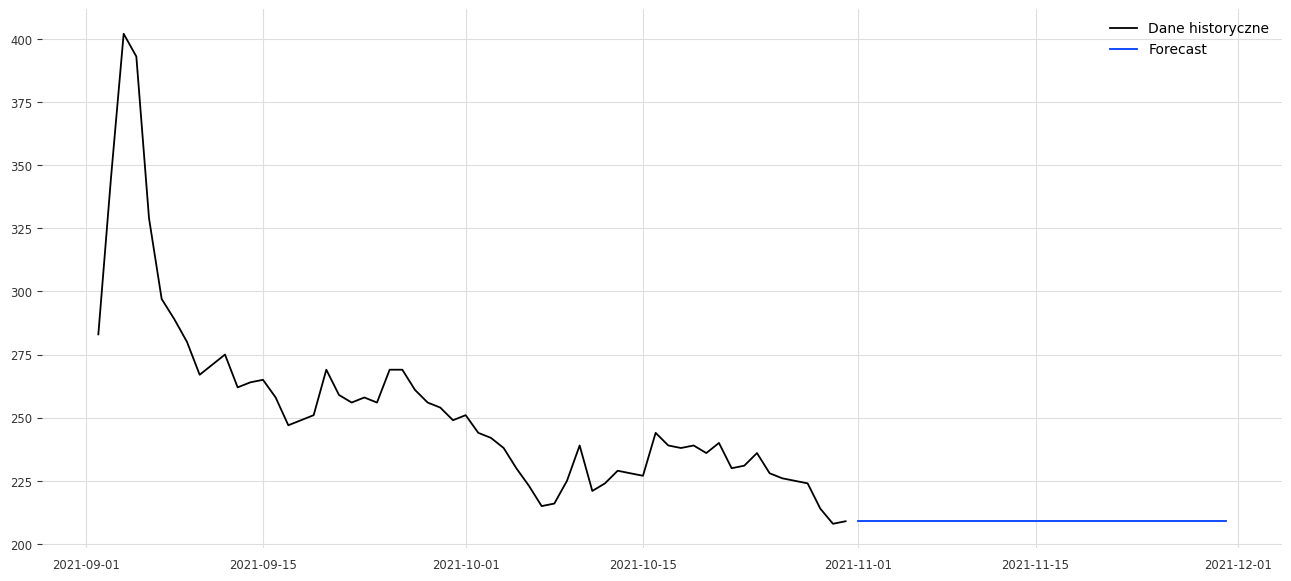

In [14]:
baseline_forecast = baseline_model.predict(horizons)
baseline_forecast = baseline_forecast.pd_dataframe().reset_index(drop=False)
baseline_forecast.columns = baseline_forecast.columns
baseline_forecast.columns.name = None

baseline_forecast['Model'] = 'Baseline'
baseline_forecast['Zmienne'] = None

target_to_viz = 'GŁOGÓW (151160060) Stan wody [cm]'

plt.figure(figsize=(16, 7))

plt.plot(dataset_ts[target_to_viz].time_index[-60:], 
         dataset_ts[target_to_viz].values()[-60:],
         label=f'Dane historyczne')
plt.plot(baseline_forecast['Data'], 
         baseline_forecast[target_to_viz], label=f'Forecast')

plt.legend(loc='upper right')
plt.show()

In [15]:
baseline_historical_forecasts = {}
baseline_metrics = {}

backtests_results_baseline = {}

for target in hydro_cols:
    backtests_results_baseline[target] = {}
    baseline_historical_forecasts[target] = pd.DataFrame()
    baseline_historical_forecasts[target].index = test_dataset.time_index
    baseline_historical_forecasts[target]['Model'] = 'Baseline'
    baseline_historical_forecasts[target]['Stacja'] = target
    baseline_historical_forecasts[target]['Zmienne'] = None
    
    baseline_metrics[target] = pd.DataFrame()
    baseline_metrics[target].index = [f'Forecast_-{horizon}D' for horizon in range(1, horizons+1)]
    baseline_metrics[target]['Model'] = 'Baseline'
    baseline_metrics[target]['Stacja'] = target
    baseline_metrics[target]['Zmienne'] = None
    
    for horizon in range(1, horizons+1):
        # Forecast for selected horizon
        backtests_results_baseline[target][horizon] = {}
        backtests_results_baseline[target][horizon]['forecast'] = take_backtest_horizon(
            backtests=backtests_baseline, horizon=horizon, last_horizon=horizons, observations=len(test_dataset), col=target)
        baseline_historical_forecasts[target][
            f'Forecast_-{horizon}D'] = backtests_results_baseline[target][horizon]['forecast'].values()
        # evaluation metric for selected horizon on test set
        baseline_metrics[target].loc[f'Forecast_-{horizon}D', 'MAPE'] = mean_absolute_percentage_error(
            y_true=test_dataset[target].values(), y_pred=backtests_results_baseline[target][horizon]['forecast'].values())
        baseline_metrics[target].loc[f'Forecast_-{horizon}D', 'BIAS'] = BIAS(
            y_true=test_dataset[target].values(), y_pred=backtests_results_baseline[target][horizon]['forecast'].values())

MAPE: 0.087
BIAS: 0.064


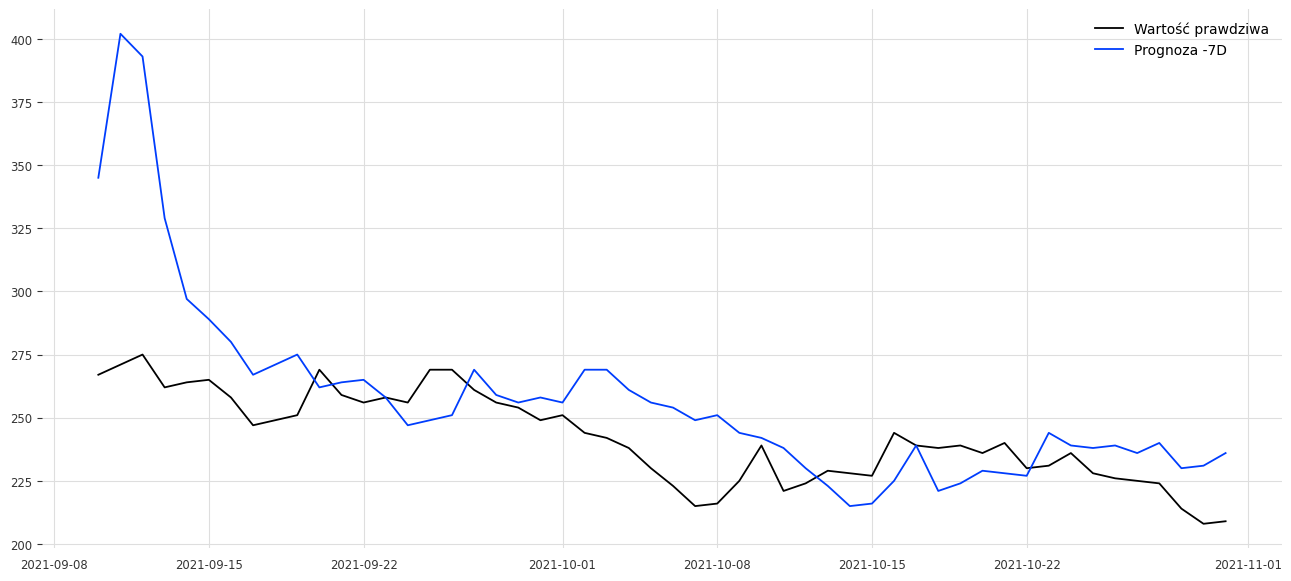

In [16]:
target_to_viz = 'GŁOGÓW (151160060) Stan wody [cm]'
horizon_to_viz = 7
print(f"MAPE: {np.round(baseline_metrics[target_to_viz].loc[f'Forecast_-{horizon_to_viz}D', 'MAPE'], 3)}")
print(f"BIAS: {np.round(baseline_metrics[target_to_viz].loc[f'Forecast_-{horizon_to_viz}D', 'BIAS'], 3)}")
plt.figure(figsize=(16, 7))

plt.plot(test_dataset[target_to_viz].time_index, test_dataset[target_to_viz].values(), label='Wartość prawdziwa')
plt.plot(baseline_historical_forecasts[target_to_viz].index, 
         baseline_historical_forecasts[target_to_viz][f'Forecast_-{horizon_to_viz}D'], label=f'Prognoza -{horizon_to_viz}D')

plt.legend(loc='upper right')
plt.show()

## 4.2 BayesianRidge

### 4.2.1 Past-observed covariates

### 4.2.2 Past-observed covariates + Future-known covariates

## 4.3 Temporal Fusion Transformer

### 4.3.1 Past-observed covariates

### 4.3.2 Past-observed covariates + Future-known covariates

# 5. Save Results

In [17]:
models_metrics = pd.DataFrame()
models_historical_forecasts = pd.DataFrame()

for target in hydro_cols:
    models_metrics = pd.concat([models_metrics, baseline_metrics[target].reset_index().rename({'index': 'horizon'}, axis=1)], 
                               axis=0)
    models_historical_forecasts = pd.concat([models_historical_forecasts, baseline_historical_forecasts[target].reset_index()], 
                                            axis=0)
    
models_historical_forecasts.reset_index(drop=True, inplace=True)
models_metrics.reset_index(drop=True, inplace=True)

In [18]:
models_historical_forecasts.to_csv('../results/historical_forecasts.csv', index=False)
models_historical_forecasts

,Data,Model,Stacja,Zmienne,Forecast_-1D,Forecast_-2D,Forecast_-3D,Forecast_-4D,Forecast_-5D,Forecast_-6D,...,Forecast_-21D,Forecast_-22D,Forecast_-23D,Forecast_-24D,Forecast_-25D,Forecast_-26D,Forecast_-27D,Forecast_-28D,Forecast_-29D,Forecast_-30D
0,2021-09-10,Baseline,GŁOGÓW (151160060) Stan wody [cm],None,280.0,289.0,297.0,329.0,393.0,402.0,...,215.0,192.0,194.0,217.0,223.0,234.0,243.0,245.0,249.0,258.0
1,2021-09-11,Baseline,GŁOGÓW (151160060) Stan wody [cm],None,267.0,280.0,289.0,297.0,329.0,393.0,...,200.0,215.0,192.0,194.0,217.0,223.0,234.0,243.0,245.0,249.0
2,2021-09-12,Baseline,GŁOGÓW (151160060) Stan wody [cm],None,271.0,267.0,280.0,289.0,297.0,329.0,...,188.0,200.0,215.0,192.0,194.0,217.0,223.0,234.0,243.0,245.0
3,2021-09-13,Baseline,GŁOGÓW (151160060) Stan wody [cm],None,275.0,271.0,267.0,280.0,289.0,297.0,...,186.0,188.0,200.0,215.0,192.0,194.0,217.0,223.0,234.0,243.0
4,2021-09-14,Baseline,GŁOGÓW (151160060) Stan wody [cm],None,262.0,275.0,271.0,267.0,280.0,289.0,...,195.0,186.0,188.0,200.0,215.0,192.0,194.0,217.0,223.0,234.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,2021-10-27,Baseline,RACIBÓRZ-MIEDONIA (150180060) Stan wody [cm],None,129.0,132.0,132.0,132.0,133.0,134.0,...,139.0,140.0,142.0,143.0,145.0,147.0,147.0,146.0,148.0,149.0
100,2021-10-28,Baseline,RACIBÓRZ-MIEDONIA (150180060) Stan wody [cm],None,126.0,129.0,132.0,132.0,132.0,133.0,...,148.0,139.0,140.0,142.0,143.0,145.0,147.0,147.0,146.0,148.0
101,2021-10-29,Baseline,RACIBÓRZ-MIEDONIA (150180060) Stan wody [cm],None,126.0,126.0,129.0,132.0,132.0,132.0,...,143.0,148.0,139.0,140.0,142.0,143.0,145.0,147.0,147.0,146.0
102,2021-10-30,Baseline,RACIBÓRZ-MIEDONIA (150180060) Stan wody [cm],None,124.0,126.0,126.0,129.0,132.0,132.0,...,139.0,143.0,148.0,139.0,140.0,142.0,143.0,145.0,147.0,147.0


In [19]:
models_metrics.to_csv('../results/models_metrics.csv', index=False)
models_metrics

,horizon,Model,Stacja,Zmienne,MAPE,BIAS
0,Forecast_-1D,Baseline,GŁOGÓW (151160060) Stan wody [cm],None,0.023274,0.005642
1,Forecast_-2D,Baseline,GŁOGÓW (151160060) Stan wody [cm],None,0.035500,0.012079
2,Forecast_-3D,Baseline,GŁOGÓW (151160060) Stan wody [cm],None,0.042007,0.018675
3,Forecast_-4D,Baseline,GŁOGÓW (151160060) Stan wody [cm],None,0.051880,0.027018
4,Forecast_-5D,Baseline,GŁOGÓW (151160060) Stan wody [cm],None,0.062913,0.040369
5,Forecast_-6D,Baseline,GŁOGÓW (151160060) Stan wody [cm],None,0.075550,0.054355
6,Forecast_-7D,Baseline,GŁOGÓW (151160060) Stan wody [cm],None,0.086819,0.063652
7,Forecast_-8D,Baseline,GŁOGÓW (151160060) Stan wody [cm],None,0.090937,0.067387
8,Forecast_-9D,Baseline,GŁOGÓW (151160060) Stan wody [cm],None,0.095796,0.069692
9,Forecast_-10D,Baseline,GŁOGÓW (151160060) Stan wody [cm],None,0.101316,0.070407


In [20]:
models_forecast = baseline_forecast.copy()
models_forecast.to_csv('../results/models_forecast.csv', index=False)
models_forecast

,Data,GŁOGÓW (151160060) Stan wody [cm],RACIBÓRZ-MIEDONIA (150180060) Stan wody [cm],Model,Zmienne
0,2021-11-01,209.0,121.0,Baseline,None
1,2021-11-02,209.0,121.0,Baseline,None
2,2021-11-03,209.0,121.0,Baseline,None
3,2021-11-04,209.0,121.0,Baseline,None
4,2021-11-05,209.0,121.0,Baseline,None
5,2021-11-06,209.0,121.0,Baseline,None
6,2021-11-07,209.0,121.0,Baseline,None
7,2021-11-08,209.0,121.0,Baseline,None
8,2021-11-09,209.0,121.0,Baseline,None
9,2021-11-10,209.0,121.0,Baseline,None
